В проекте мы:
- Проанализируем набор данных по играм с помощью pandas, seaborn, matplotlib и plotly

Мы визуализируем:
1. Топ 10 пользователей по времени проведенному в играх
2. Топ 50 игр, в которые играют больше всего
3. Топ 50 игр, которые покупают чаще всего

- Составим систему рекомендаций (Collaborative filtering)

Датасет взят из https://www.kaggle.com/code/simonprevoteaux/steam-game-analysis

## 1. Подготовка данных

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from plotly import graph_objects as go
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("/content/steam-200k.csv", header=None, index_col=None, names=['UserID', 'Game', 'Action', 'Hours', '0'])
df.head()

,UserID,Game,Action,Hours,0
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0,0
1,151603712,The Elder Scrolls V Skyrim,play,273.0,0
2,151603712,Fallout 4,purchase,1.0,0
3,151603712,Fallout 4,play,87.0,0
4,151603712,Spore,purchase,1.0,0


In [3]:
df.shape[0]

200000

### 1.1. Подготовка данных

In [4]:
#удалим ненужные колонки
df.drop(columns = ['0'], inplace = True)

In [5]:
df.isna().any()
#пропусков нет

UserID    False
Game      False
Action    False
Hours     False
dtype: bool

###1.2. Разделим наш датасет по значениям в Action

In [6]:
play_df = df[df['Action'] == 'play']
purchase_df = df[df['Action'] == 'purchase']

##Анализ данных

### 2.1. Топ пользователей по времени проведенному в играх

In [7]:
#сгруппируем и выведем первые десять
p_hours = play_df.groupby('UserID')['Hours'].sum().sort_values(ascending = False).iloc[:10]
sorted_index = p_hours.sort_values(ascending=False).index

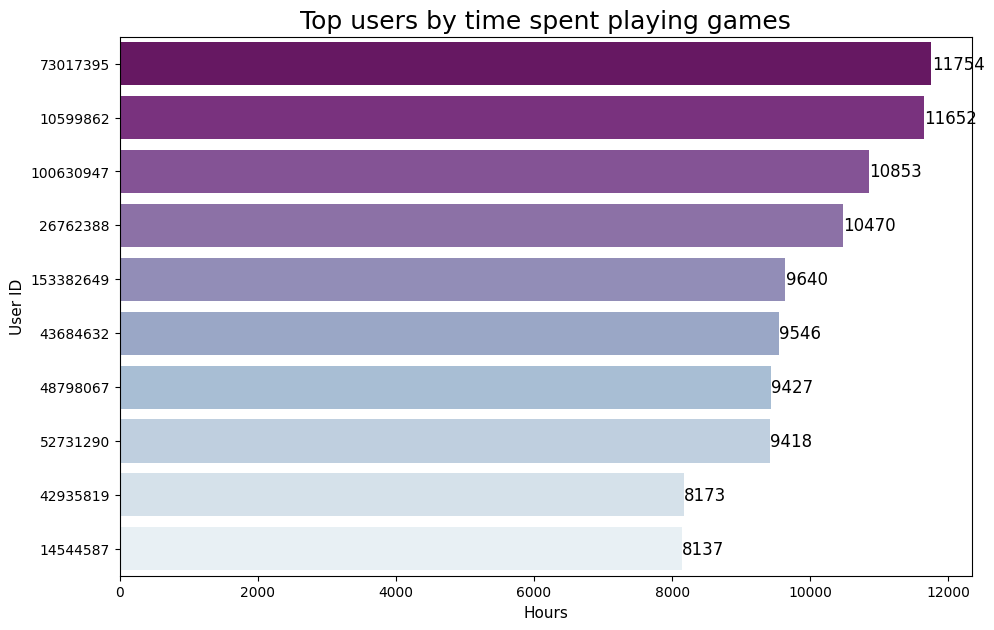

In [8]:
colors = sns.color_palette('BuPu_r', n_colors=len(p_hours))
fig, ax = plt.subplots(figsize = (11, 7))

sns.barplot(y = p_hours.index, x = p_hours.values, ax=ax, palette = colors, orient='h', order=sorted_index)

ax.set_ylabel('User ID', fontsize = 11)
ax.set_xlabel('Hours', fontsize = 11)
plt.title("Top users by time spent playing games", fontsize=18)

for i in ax.patches:
    ax.text(i.get_width()+3, i.get_y()+.5, str(round(i.get_width())), fontsize=12)

plt.show()


Первый четыре пользователя провели в играх очень большое количество времени, в пересчете на дни почти 458 дней или около 15 месяцев!

### 2.2. Какие игры играют больше всего?

In [9]:
#выведем первые 50
g_hours = play_df.groupby('Game')['Hours'].sum().sort_values(ascending = False).head(50)

In [10]:
#построим интерактивную таблицу с помошью plotly
fig = go.Figure(data=[
    go.Bar(y=g_hours.index,
           x=g_hours.values,
           text=g_hours.values,
           orientation='h',
           marker_color='indianred')],
    layout=dict(height=1000))

fig.update_traces(textposition='outside')
fig.update_layout(yaxis=dict(autorange="reversed"))

fig.show()

Первенство за многопользовательской игрой Dota. За ними также многопользовательские игры, такие как Counter Strike и Team Fortress. Из однопользвательских игр в верхник строчках топа только стратегия Civilization (с возможностью мультиплеерной игры) и ролевая игра в сеттинге средневековья TES Skyrim.

### 2.3. Какие игры больше всего купили?

In [11]:
#Также возьмем первые 50
g_purchase = purchase_df.groupby('Game')['Hours'].count()
g_purchase = g_purchase.sort_values(ascending = False).head(50)

In [12]:
fig = go.Figure(data=[
    go.Bar(y=g_purchase.index,
           x=g_purchase.values,
           text=g_purchase.values,
           orientation='h',
           marker_color='#2ca02c')],
    layout=dict(height=1000))

fig.update_traces(textposition='outside')
fig.update_layout(yaxis=dict(autorange="reversed"))

fig.show()

Первые по покупкам все также многопользовательские игры. Однако, на втором месте здесь стоит игра из середины предыдущего топа Unturned - инди-игра с зомби-тематикой в жанре песочницы. Стоит отметить, что игра на первой строчке топа - Dota 2, доступна для скачивания бесплатно.  

## 2. Подготовка данных к рекомендациям
В построении рекомендательной системы мы будем опираться на метод Collaborative Filtering.

Collaborative Filtering - это метод рекомендации, который использует информацию о предпочтениях пользователей для нахождения сходства между пользователями или элементами и предсказания рекомендаций на основе этого сходства

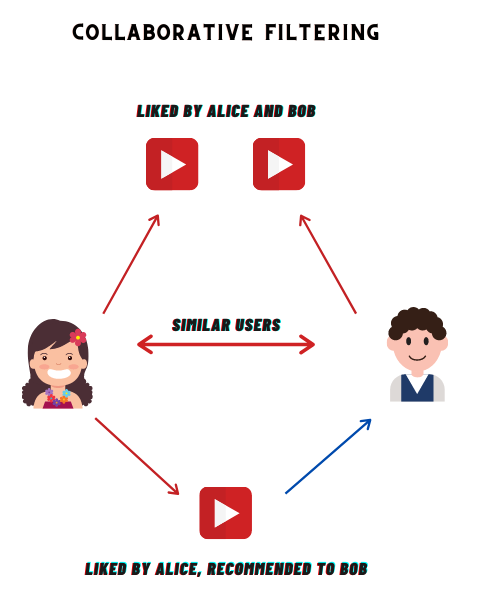

### 2.1. Уберем из рекомендаций тех, кто играл менее чем в три игры

In [13]:
u_purchases = purchase_df.groupby(['UserID'])['Hours'].count().sort_values(ascending = False)
u_purchases = u_purchases[u_purchases>3].index

sorted_df = purchase_df[purchase_df['UserID'].isin(u_purchases)]
sorted_df = sorted_df.groupby(['UserID', "Game"])['Hours'].count()

### 2.2. Сделаем группировку по пользователям и играм

Сделаем матрицу пользователь-игра, где в ячейках будет факт покупки игры - 1 и 0, если у пользователя нет такой игры.

In [14]:
matrix = sorted_df.unstack('Game').applymap(lambda x: 1 if x > 0 else 0)
matrix

Game,007 Legends,0RBITALIS,1... 2... 3... KICK IT! (Drop That Beat Like an Ugly Baby),10 Second Ninja,"10,000,000",100% Orange Juice,1000 Amps,12 Labours of Hercules,12 Labours of Hercules II The Cretan Bull,12 Labours of Hercules III Girl Power,...,rFactor 2,realMyst,realMyst Masterpiece Edition,resident evil 4 / biohazard 4,rymdkapsel,sZone-Online,samurai_jazz,the static speaks my name,theHunter,theHunter Primal
UserID,,,,,,,,,,,,,,,,,,,,,
5250,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
76767,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
86540,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
103360,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
144736,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306690580,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
306971738,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
306993682,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 3. Система рекомендаций
Схожесть игровых интересов пользователей мы будем определять с помощью косинусной похожести (вычисление угла между векторами)

### 3.1. Найдем косинусные похожести пользователей с помощью cosine_similarity



In [15]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(matrix, matrix)

In [16]:
#переведем матрицу похожести в датафрейм, где по индексам - ID пользователя, по столбцам - ID пользователя
cosine_sim_df = pd.DataFrame(cosine_sim)
cosine_sim_df.columns = matrix.index
cosine_sim_df['UserID'] = matrix.index
cosine_sim_df = cosine_sim_df.set_index('UserID')

cosine_sim_df

UserID,5250,76767,86540,103360,144736,181212,229911,298950,299153,381543,...,304081461,304971849,305190256,306042038,306547522,306690580,306971738,306993682,308695132,309404240
UserID,,,,,,,,,,,,,,,,,,,,,
5250,1.000000,0.400066,0.313276,0.552052,0.617213,0.755929,0.671937,0.284747,0.699854,0.552052,...,0.000000,0.000000,0.0,0.000000,0.164957,0.000000,0.0,0.0,0.0,0.09759
76767,0.400066,1.000000,0.239268,0.421637,0.471405,0.433013,0.416975,0.217479,0.400892,0.421637,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.00000
86540,0.313276,0.239268,1.000000,0.279372,0.312348,0.286910,0.233778,0.226442,0.265627,0.279372,...,0.000000,0.000000,0.0,0.000000,0.000000,0.220863,0.0,0.0,0.0,0.00000
103360,0.552052,0.421637,0.279372,1.000000,0.894427,0.730297,0.608581,0.157195,0.845154,1.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.00000
144736,0.617213,0.471405,0.312348,0.894427,1.000000,0.816497,0.544331,0.175750,0.755929,0.894427,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306690580,0.000000,0.000000,0.220863,0.000000,0.000000,0.000000,0.000000,0.093205,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.00000
306971738,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.023486,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.00000
306993682,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.333333,0.000000,0.0,0.000000,0.188982,0.000000,0.0,1.0,0.0,0.00000


### 3.2. Найдем игры пользователя максимально похожего на пользователя 65117175

In [17]:
#выведем игры пользователя 65117175
A = matrix.loc[65117175]
A_games = A[A > 0].index.tolist()
A_games

['1... 2... 3... KICK IT! (Drop That Beat Like an Ugly Baby)',
 'A Virus Named TOM',
 'AaAaAA!!! - A Reckless Disregard for Gravity',
 "Alan Wake's American Nightmare",
 'Alien Breed 2 Assault',
 "Amerzone The Explorer's Legacy",
 'Amnesia The Dark Descent',
 'And Yet It Moves',
 'Aquaria',
 'Atom Zombie Smasher ',
 'Audiosurf',
 'BIT.TRIP BEAT',
 'BIT.TRIP RUNNER',
 "Back to the Future Ep 1 - It's About Time",
 'Back to the Future Ep 2 - Get Tannen!',
 'Back to the Future Ep 3 - Citizen Brown',
 'Back to the Future Ep 4 - Double Visions',
 'Back to the Future Ep 5 - OUTATIME',
 'Bastion',
 'Botanicula',
 'Braid',
 'Broken Age',
 'Cloud Chamber',
 'Cogs',
 'Costume Quest',
 'Costume Quest 2',
 'Crayon Physics Deluxe',
 'Critical Mass',
 'Dead Bits',
 'Dear Esther',
 'Defense Grid 2',
 'Defense Grid 2 A Matter of Endurance',
 'Defense Grid Containment DLC',
 'Defense Grid Resurgence Map Pack 1',
 'Defense Grid Resurgence Map Pack 2 ',
 'Defense Grid Resurgence Map Pack 3',
 'Defense Gri

In [18]:
#выведем игры пользователя, который больше всего похож на 65117175
most_sim = cosine_sim_df.loc[65117175].sort_values(ascending=False).index[1]
B = matrix.loc[most_sim]
B_games = B[B > 0].index.tolist()
B_games

['1... 2... 3... KICK IT! (Drop That Beat Like an Ugly Baby)',
 'AaAaAA!!! - A Reckless Disregard for Gravity',
 'Amnesia The Dark Descent',
 'Audiosurf',
 'BIT.TRIP BEAT',
 'BIT.TRIP RUNNER',
 'Cogs',
 'Defense Grid The Awakening',
 'Jamestown',
 'Killing Floor',
 'Killing Floor Mod Defence Alliance 2',
 'NightSky',
 'Portal',
 'RUSH',
 'Shank',
 'Super Meat Boy',
 'The Ball',
 'The Wonderful End of the World',
 'Toki Tori']

### 3.3. Найдем те игры, которые можно порекомендовать пользователю 65117175

In [19]:
items_to_recommend_to_A = set(B_games) - set(A_games)
items_to_recommend_to_A

set()

Таких игр не оказалось. Похоже наш пользователь купил во все игры, которые мы нашли у похожего пользователя. Ничего страшного. Попробуем сделать рекомендации нашему пользвателя с помощью функции.

## 4. Функции для рекомендаций игр

### 4.1. Первая функция будет находить топ три похожих пользователей игровые интересы которого, похожи на нашего пользователя

Подобный список можно выводить как для ознакомления с профилями похожих пользователей и самостоятельного изучения списка игр, так и для добавления в друзья, общения и совместных игр

На вход функция принимает:
- ID пользователя
- Матрицу косинусных похожестей

На выходе функции:
- ID топ три похожих пользователей

In [20]:
def friend_suggester(x, y = cosine_sim_df):
  return y.loc[x].sort_values(ascending=False).index[1:4].tolist()

friend_suggester(65117175)

[78560022, 39446138, 80119032]

### 4.2. Вторая функция будет получать уникальные игры для рекомендации опираясь на полученные данные с первой функции

Функция на вход принимает:
- ID пользователя
- Матрицу пользователь-игра

На выходе функции:
- Множество игр

In [21]:
def game_suggester(x, y = matrix):
  friend_list=friend_suggester(x)
  games_for_user = set()

  user = matrix.loc[x]
  user_games = user[user > 0].index.tolist()
  for idx, id in enumerate(friend_list):
    friend = matrix.loc[id]
    friend_games = friend[friend > 0].index.tolist()
    games_for_user.update((set(friend_games) - set(user_games)))
  return games_for_user

game_suggester(65117175)

{'Cortex Command',
 'Dead Island',
 'Firefall',
 'Goat Simulator',
 'LIMBO',
 "Lone Survivor The Director's Cut",
 'Space Hack',
 'Superbrothers Sword & Sworcery EP',
 'The Expendabros'}